In [1]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## Reading files

### Read training files:

In [2]:
flag_trainDF = pd.read_csv("data/train/train_flag.csv")
flag_trainDF

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0
...,...,...,...
261378,BAO14050568,Cash loans,0
261379,NDO00278120,Cash loans,0
261380,LDY78194712,Cash loans,0
261381,EVH98380736,Revolving loans,0


In [3]:
def load_json_files(path):
    """
    Utility function to load json files as DataFrame
    """
    jsonFile = open(path)
    data = json.load(jsonFile)
    json_df = pd.DataFrame(list(chain.from_iterable(data)))
    return json_df

In [4]:
enq_trainDF = load_json_files('data/train/enquiry_data_train.json')
enq_trainDF.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [5]:
acc_trainDF = load_json_files('data/train/accounts_data_train.json')
acc_trainDF.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


### Read testing data:

In [6]:
flag_testDF = pd.read_csv("data/test/test_flag.csv")
enq_testDF = load_json_files('data/test/enquiry_data_test.json')
acc_testDF = load_json_files('data/test/accounts_data_test.json')

In [7]:
print("Shape of training flag data: {}".format(flag_trainDF.shape))
print("Shape of training enq data: {}".format(enq_trainDF.shape))
print("Shape of training Acc data: {}".format(acc_trainDF.shape))

print("Shape of testing flag data: {}".format(flag_testDF.shape))
print("Shape of testing enq data: {}".format(enq_testDF.shape))
print("Shape of testing Acc data: {}".format(acc_testDF.shape))


Shape of training flag data: (261383, 3)
Shape of training enq data: (1909926, 4)
Shape of training Acc data: (1245310, 7)
Shape of testing flag data: (46127, 2)
Shape of testing enq data: (337662, 4)
Shape of testing Acc data: (220013, 7)


## EDA

### For Flag DataFrame:

In [8]:
# Check if any null values
flag_trainDF.isnull().sum()

uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64

In [9]:
flag_trainDF.dtypes

uid                   object
NAME_CONTRACT_TYPE    object
TARGET                 int64
dtype: object

In [10]:
flag_trainDF["NAME_CONTRACT_TYPE"].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

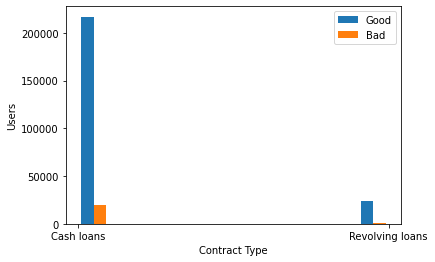

In [11]:
good_loan = flag_trainDF[flag_trainDF.TARGET == 0].NAME_CONTRACT_TYPE
bad_loan = flag_trainDF[flag_trainDF.TARGET == 1].NAME_CONTRACT_TYPE

plt.hist([good_loan, bad_loan], label=("Good", "Bad"))
plt.xlabel("Contract Type")
plt.ylabel("Users")
plt.legend()

We can see that most of the loans are Cash loans

In [12]:
flag_trainDF = pd.get_dummies(flag_trainDF, columns=['NAME_CONTRACT_TYPE'], prefix='NAME_CONTRACT_TYPE')
flag_trainDF.head()

,uid,TARGET,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans
0,XDA69787158,0,1,0
1,BSE47789733,0,1,0
2,NTJ92213825,0,1,0
3,TCQ47571695,0,1,0
4,WJZ68772744,0,1,0


In [13]:
flag_testDF = pd.get_dummies(flag_testDF, columns=['NAME_CONTRACT_TYPE'], prefix='NAME_CONTRACT_TYPE')

### For Enquiry DataFrame:

In [14]:
enq_trainDF["enquiry_type"].unique()

array(['Interbank credit', 'Mobile operator loan',
       'Cash loan (non-earmarked)', 'Mortgage', 'Revolving loans',
       'Loan for purchase of shares (margin lending)', 'Cash loans',
       'Car loan', 'Another type of loan',
       'Loan for the purchase of equipment', 'Real estate loan',
       'Credit card', 'Unknown type of loan', 'Microloan',
       'Consumer credit', 'Loan for working capital replenishment',
       'Loan for business development'], dtype=object)

In [15]:
# Check if any null values are there
enq_trainDF.isnull().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

In [16]:
# See all value counts of enquiry_type
enq_trainDF["enquiry_type"].value_counts()

Cash loans                                      303108
Revolving loans                                 120181
Mobile operator loan                             99479
Real estate loan                                 99328
Microloan                                        99324
Unknown type of loan                             99280
Loan for purchase of shares (margin lending)     99230
Mortgage                                         99216
Credit card                                      99208
Another type of loan                             99154
Loan for the purchase of equipment               99152
Interbank credit                                 99063
Car loan                                         98994
Loan for business development                    98900
Cash loan (non-earmarked)                        98831
Loan for working capital replenishment           98814
Consumer credit                                  98664
Name: enquiry_type, dtype: int64

<AxesSubplot:>

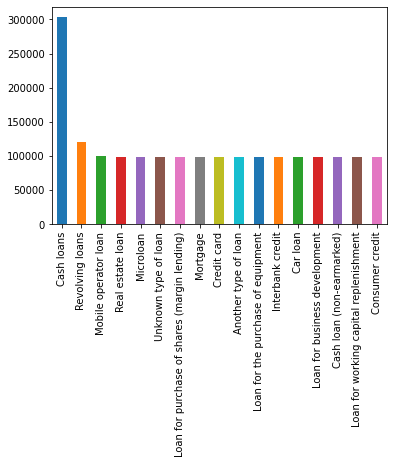

In [17]:
# Add colors for plot bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] 

enq_trainDF.enquiry_type.value_counts(dropna=False).plot(kind='bar', color=colors)

<AxesSubplot:>

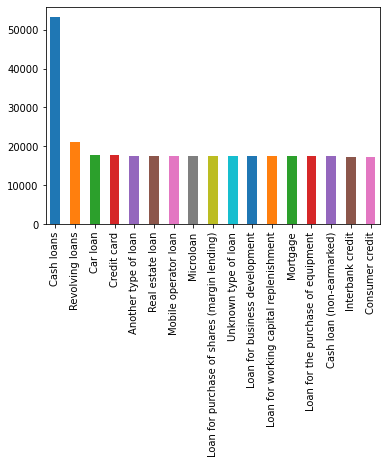

In [18]:
enq_testDF.enquiry_type.value_counts(dropna=False).plot(kind='bar', color=colors)

In [19]:
enq_trainDF[enq_trainDF.uid == "AAA09044550"]
# We can see here that a single user can enquire about more than one loan, even more than one of same type too

,enquiry_type,enquiry_amt,enquiry_date,uid
11,Cash loans,120000,2019-08-19,AAA09044550
12,Interbank credit,197000,2019-11-01,AAA09044550
13,Car loan,127000,2020-06-21,AAA09044550
14,Revolving loans,94000,2020-06-11,AAA09044550
15,Car loan,120000,2020-10-19,AAA09044550
16,Another type of loan,174000,2020-09-29,AAA09044550
17,Loan for the purchase of equipment,87000,2020-10-19,AAA09044550
18,Real estate loan,65000,2017-10-17,AAA09044550
19,Credit card,149000,2018-09-27,AAA09044550
20,Unknown type of loan,98000,2020-10-19,AAA09044550


In [20]:
# Converting date object coulum to datetime 
enq_trainDF['enquiry_date'] = pd.to_datetime(enq_trainDF['enquiry_date'])
enq_testDF['enquiry_date'] = pd.to_datetime(enq_testDF['enquiry_date'])
enq_trainDF.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [21]:
print("######## Dates range for training ########")
print(enq_trainDF.enquiry_date.min())
print(enq_trainDF.enquiry_date.max())
print("######## Dates range for testin ########")
print(enq_testDF.enquiry_date.min())
print(enq_testDF.enquiry_date.max())

######## Dates range for training ########
2015-08-30 00:00:00
2021-01-01 00:00:00
######## Dates range for testin ########
2015-11-11 00:00:00
2021-01-01 00:00:00


In [22]:
# Extracting year and month
enq_trainDF['year'] = pd.DatetimeIndex(enq_trainDF['enquiry_date']).year
enq_trainDF['month'] = pd.DatetimeIndex(enq_trainDF['enquiry_date']).month
# enq_trainDF['day'] = pd.DatetimeIndex(enq_trainDF['enquiry_date']).day
# enq_trainDF['quarter'] = pd.DatetimeIndex(enq_trainDF['enquiry_date']).quarter
enq_trainDF.head()

,enquiry_type,enquiry_amt,enquiry_date,uid,year,month
0,Interbank credit,168839,2020-11-08,AAA08065248,2020,11
1,Mobile operator loan,268392,2020-09-20,AAA08065248,2020,9
2,Mobile operator loan,36082,2020-06-19,AAA08065248,2020,6
3,Interbank credit,180467,2019-10-22,AAA08065248,2019,10
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248,2020,5


In [23]:
enq_testDF['year'] = pd.DatetimeIndex(enq_testDF['enquiry_date']).year
enq_testDF['month'] = pd.DatetimeIndex(enq_testDF['enquiry_date']).month

In [24]:
enq_trainDF

,enquiry_type,enquiry_amt,enquiry_date,uid,year,month
0,Interbank credit,168839,2020-11-08,AAA08065248,2020,11
1,Mobile operator loan,268392,2020-09-20,AAA08065248,2020,9
2,Mobile operator loan,36082,2020-06-19,AAA08065248,2020,6
3,Interbank credit,180467,2019-10-22,AAA08065248,2019,10
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248,2020,5
...,...,...,...,...,...,...
1909921,Loan for the purchase of equipment,401073,2020-02-23,ZZZ93377613,2020,2
1909922,Consumer credit,224844,2018-06-03,ZZZ93377613,2018,6
1909923,Loan for purchase of shares (margin lending),416642,2017-10-15,ZZZ93377613,2017,10
1909924,Loan for purchase of shares (margin lending),22000,2020-08-22,ZZZ93377613,2020,8


In [25]:
# One Hot Encoding to get year, month and enquiry_type in column for training data
enq_trainDF1 = pd.get_dummies(enq_trainDF, columns=['year'], drop_first=True, prefix='year')
enq_trainDF1 = pd.get_dummies(enq_trainDF1, columns=['month'], drop_first=True, prefix='month')
enq_trainDF1 = pd.get_dummies(enq_trainDF1, columns=['enquiry_type'], drop_first=True, prefix='enquiry_type')
enq_trainDF1

,enquiry_amt,enquiry_date,uid,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,month_2,...,enquiry_type_Loan for business development,enquiry_type_Loan for purchase of shares (margin lending),enquiry_type_Loan for the purchase of equipment,enquiry_type_Loan for working capital replenishment,enquiry_type_Microloan,enquiry_type_Mobile operator loan,enquiry_type_Mortgage,enquiry_type_Real estate loan,enquiry_type_Revolving loans,enquiry_type_Unknown type of loan
0,168839,2020-11-08,AAA08065248,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,268392,2020-09-20,AAA08065248,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,36082,2020-06-19,AAA08065248,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,180467,2019-10-22,AAA08065248,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,227459,2020-05-24,AAA08065248,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909921,401073,2020-02-23,ZZZ93377613,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1909922,224844,2018-06-03,ZZZ93377613,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1909923,416642,2017-10-15,ZZZ93377613,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1909924,22000,2020-08-22,ZZZ93377613,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
# One hot encoding for testing data
enq_testDF1 = pd.get_dummies(enq_testDF, columns=['year'], drop_first=True, prefix='year')
enq_testDF1 = pd.get_dummies(enq_testDF1, columns=['month'], drop_first=True, prefix='month')
enq_testDF1 = pd.get_dummies(enq_testDF1, columns=['enquiry_type'], drop_first=True, prefix='enquiry_type')
enq_testDF1

,enquiry_amt,enquiry_date,uid,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,month_2,...,enquiry_type_Loan for business development,enquiry_type_Loan for purchase of shares (margin lending),enquiry_type_Loan for the purchase of equipment,enquiry_type_Loan for working capital replenishment,enquiry_type_Microloan,enquiry_type_Mobile operator loan,enquiry_type_Mortgage,enquiry_type_Real estate loan,enquiry_type_Revolving loans,enquiry_type_Unknown type of loan
0,143000,2020-12-13,AAA02107680,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,174000,2020-12-01,AAA14437029,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,65000,2019-07-01,AAA14437029,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,118000,2020-08-05,AAA14437029,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,12000,2020-02-28,AAA14437029,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337657,199000,2020-11-08,ZZZ02221122,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
337658,145000,2020-10-16,ZZZ02221122,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
337659,93000,2020-02-10,ZZZ02221122,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
337660,119000,2020-04-08,ZZZ02221122,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [27]:
# Now we are creating some columns using enquiry dataframe

# Like one column will be mean of enquiry amount of a user
enq_trainDF1_1 = enq_trainDF1[["uid", "enquiry_amt"]]
enq_trainDF1_1 = enq_trainDF1_1.groupby('uid').mean().reset_index()
enq_trainDF1_1.rename(columns={"enquiry_amt": "enquiry_amt_mean"}, inplace=True)
enq_trainDF1_1.head()

,uid,enquiry_amt_mean
0,AAA08065248,187696.181818
1,AAA09044550,102269.230769
2,AAA10545297,94071.428571
3,AAA14112888,97666.666667
4,AAA20326915,66000.000000


In [28]:
enq_trainDF1_2 = enq_trainDF1.drop(['enquiry_date'], axis=1)
# We are also calculating sum, for eg year_2021 will tell how many loans were enquired by user in year 2021
enq_trainDF1_2 = enq_trainDF1_2.groupby('uid').sum().reset_index()
enq_trainDF1_2.head()

,uid,enquiry_amt,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,month_2,month_3,...,enquiry_type_Loan for business development,enquiry_type_Loan for purchase of shares (margin lending),enquiry_type_Loan for the purchase of equipment,enquiry_type_Loan for working capital replenishment,enquiry_type_Microloan,enquiry_type_Mobile operator loan,enquiry_type_Mortgage,enquiry_type_Real estate loan,enquiry_type_Revolving loans,enquiry_type_Unknown type of loan
0,AAA08065248,2064658,0,0,0,4,7,0,1,1,...,0,2,0,0,0,2,1,0,2,0
1,AAA09044550,2659000,0,1,1,5,19,0,1,2,...,0,0,1,0,2,1,1,1,1,1
2,AAA10545297,1317000,0,0,1,4,9,0,1,2,...,0,1,0,0,0,0,0,0,2,1
3,AAA14112888,1465000,0,1,1,6,7,0,0,2,...,0,2,2,2,0,2,0,0,0,1
4,AAA20326915,66000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
# Similarly for test data
enq_testDF1_1 = enq_testDF1[["uid", "enquiry_amt"]]
enq_testDF1_1 = enq_testDF1_1.groupby('uid').mean().reset_index()
enq_testDF1_1.rename(columns={"enquiry_amt": "enquiry_amt_mean"}, inplace=True)

enq_testDF1_2 = enq_testDF1.drop(['enquiry_date'], axis=1)
enq_testDF1_2 = enq_testDF1_2.groupby('uid').sum().reset_index()

In [30]:
# Then we will join the dataframes to get mean and sum value both for each user
enq_trainDF_final = pd.merge(enq_trainDF1_1, enq_trainDF1_2, how="inner", on="uid")
enq_trainDF_final.head()

,uid,enquiry_amt_mean,enquiry_amt,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,month_2,...,enquiry_type_Loan for business development,enquiry_type_Loan for purchase of shares (margin lending),enquiry_type_Loan for the purchase of equipment,enquiry_type_Loan for working capital replenishment,enquiry_type_Microloan,enquiry_type_Mobile operator loan,enquiry_type_Mortgage,enquiry_type_Real estate loan,enquiry_type_Revolving loans,enquiry_type_Unknown type of loan
0,AAA08065248,187696.181818,2064658,0,0,0,4,7,0,1,...,0,2,0,0,0,2,1,0,2,0
1,AAA09044550,102269.230769,2659000,0,1,1,5,19,0,1,...,0,0,1,0,2,1,1,1,1,1
2,AAA10545297,94071.428571,1317000,0,0,1,4,9,0,1,...,0,1,0,0,0,0,0,0,2,1
3,AAA14112888,97666.666667,1465000,0,1,1,6,7,0,0,...,0,2,2,2,0,2,0,0,0,1
4,AAA20326915,66000.000000,66000,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [31]:
# Similarly for testing data
enq_testDF_final = pd.merge(enq_testDF1_1, enq_testDF1_2, how="inner", on="uid")
enq_testDF_final.head()

,uid,enquiry_amt_mean,enquiry_amt,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,month_2,...,enquiry_type_Loan for business development,enquiry_type_Loan for purchase of shares (margin lending),enquiry_type_Loan for the purchase of equipment,enquiry_type_Loan for working capital replenishment,enquiry_type_Microloan,enquiry_type_Mobile operator loan,enquiry_type_Mortgage,enquiry_type_Real estate loan,enquiry_type_Revolving loans,enquiry_type_Unknown type of loan
0,AAA02107680,143000.000000,143000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAA14437029,92250.000000,369000,0,0,0,1,3,0,1,...,0,0,0,2,0,0,0,1,0,0
2,AAB12915377,137000.000000,137000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,AAB55088883,78928.571429,1105000,0,0,1,4,9,0,0,...,1,0,1,0,1,0,1,1,0,2
4,AAB68152393,116882.352941,1987000,0,0,2,5,9,1,0,...,2,1,1,2,0,1,0,1,2,1


In [32]:
enq_trainDF_final.shape

(261383, 36)

### For Accounts DataFrame:

In [33]:
# Check null values
acc_trainDF.isnull().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

In [34]:
acc_testDF.isnull().sum()

credit_type                0
loan_amount                0
amount_overdue             0
open_date                  0
closed_date            81636
payment_hist_string        0
uid                        0
dtype: int64

In [35]:
# Here we can see count if very less we can drop these here
acc_trainDF.loc[acc_trainDF["loan_amount"].isnull()]
# Also we are not focusing on closed_date while treating null values because it denotes loan is active or not

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901
149202,Another type of loan,NaN,0.0,2021-01-01,NaN,,DCX71532515
613183,Another type of loan,NaN,0.0,2021-01-01,NaN,,MVG95017452


In [36]:
acc_trainDF = acc_trainDF[acc_trainDF['loan_amount'].notna()]
acc_trainDF.isnull().sum()

credit_type                 0
loan_amount                 0
amount_overdue              0
open_date                   0
closed_date            463033
payment_hist_string         0
uid                         0
dtype: int64

In [37]:
# Random check
acc_trainDF.loc[acc_trainDF["uid"]=="AAA20326915"]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
4,Credit card,10480.5,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915
5,Consumer credit,46696.5,0.0,2016-11-20,2017-10-06,000000000000000000000000000000,AAA20326915
6,Credit card,0.0,0.0,2014-09-10,2018-08-30,0000000000000000000000000000000000000000000000...,AAA20326915
7,Consumer credit,117000.0,0.0,2018-02-04,2018-05-06,000000000,AAA20326915
8,Consumer credit,90000.0,0.0,2020-03-12,2020-04-12,000,AAA20326915
9,Consumer credit,235800.0,0.0,2020-03-29,2020-05-13,000,AAA20326915
10,Consumer credit,46620.0,0.0,2020-06-22,NaN,000000000000000000,AAA20326915
11,Credit card,45000.0,0.0,2020-06-28,NaN,000000000000000000,AAA20326915


In [38]:
# Random check
enq_trainDF.loc[enq_trainDF["uid"]=="AAA20326915"]

# We can see entries don't match in both dataframes

,enquiry_type,enquiry_amt,enquiry_date,uid,year,month
66,Mobile operator loan,66000,2020-08-14,AAA20326915,2020,8


<AxesSubplot:>

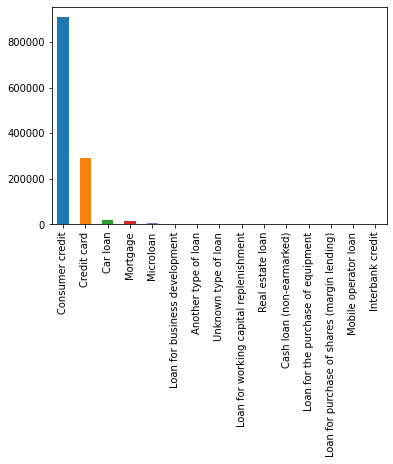

In [39]:
acc_trainDF.credit_type.value_counts(dropna=False).plot(kind='bar', color=colors)

In [40]:
acc_trainDF.credit_type.value_counts()

Consumer credit                                 908741
Credit card                                     292422
Car loan                                         20237
Mortgage                                         13196
Microloan                                         7766
Loan for business development                     1466
Another type of loan                               729
Unknown type of loan                               374
Loan for working capital replenishment             320
Real estate loan                                    17
Cash loan (non-earmarked)                           17
Loan for the purchase of equipment                  16
Loan for purchase of shares (margin lending)         4
Mobile operator loan                                 1
Interbank credit                                     1
Name: credit_type, dtype: int64

In [1]:
# Some features which can be added from accounts data are: Active loan yes or no, total_amount_overdue, total_loan_amount, top 5 credit_type one hot encoding, total_due_dates

# This logic was once used in competition where instead of making all values hot encoded, we can do for top n values
# To get whole set of dummy variables, for all the categorical variables
def one_hot_encoding(df, variable, top_x_labels):
    # function to create the dummy variables for the most frequent labels
    # we can vary the number of most frequent labels that we encode
    
    for label in top_x_labels:
        df[variable+'_'+label] = np.where(df[variable]==label, 1, 0)


In [42]:
# As we saw in above graph, we can use top 5 for hot encoding
top5 = [x for x in acc_trainDF.credit_type.value_counts().sort_values(ascending=False).head(5).index]
top5

['Consumer credit', 'Credit card', 'Car loan', 'Mortgage', 'Microloan']

In [43]:
one_hot_encoding(acc_trainDF, 'credit_type', top5)
one_hot_encoding(acc_testDF, 'credit_type', top5)
acc_trainDF.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,credit_type_Consumer credit,credit_type_Credit card,credit_type_Car loan,credit_type_Mortgage,credit_type_Microloan
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,1,0,0,0,0
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,1,0,0,0,0
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,0,1,0,0,0
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,1,0,0,0,0
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,0,1,0,0,0


In [44]:
# If not getting good scores still then add amount as features

In [45]:
# Now we will add payment_hist_string, as it tells how many days user was due
# So big sum number means he has passed due dates more times compared to user with small sum
def getSum(n):
     
    strr = str(n)
    list_of_number = list(map(int, strr.strip()))
    return sum(list_of_number)

acc_trainDF["payment_due_count"] = acc_trainDF["payment_hist_string"].apply(getSum)
acc_testDF["payment_due_count"] = acc_testDF["payment_hist_string"].apply(getSum)

In [46]:
acc_trainDF.dtypes

credit_type                     object
loan_amount                    float64
amount_overdue                 float64
open_date                       object
closed_date                     object
payment_hist_string             object
uid                             object
credit_type_Consumer credit      int64
credit_type_Credit card          int64
credit_type_Car loan             int64
credit_type_Mortgage             int64
credit_type_Microloan            int64
payment_due_count                int64
dtype: object

In [47]:
# Active loan or not
# If closed date is NaN then user has active loan
acc_trainDF["active_loans"] = acc_trainDF['closed_date'].where(acc_trainDF['closed_date'].isnull(), 1).fillna(0).astype(int)
acc_testDF["active_loans"] = acc_testDF['closed_date'].where(acc_testDF['closed_date'].isnull(), 1).fillna(0).astype(int)
acc_trainDF

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,credit_type_Consumer credit,credit_type_Credit card,credit_type_Car loan,credit_type_Mortgage,credit_type_Microloan,payment_due_count,active_loans
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,1,0,0,0,0,1,1
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,1,0,0,0,0,13,1
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,0,1,0,0,0,0,0
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,1,0,0,0,0,0,1
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,0,1,0,0,0,482,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245305,Consumer credit,100116.000,0.0,2017-05-12,2017-06-15,000,ZZZ93377613,1,0,0,0,0,0,1
1245306,Consumer credit,34839.000,0.0,2016-11-11,2017-12-17,000000000000000000000000000000000000000,ZZZ93377613,1,0,0,0,0,0,1
1245307,Consumer credit,18589.500,0.0,2015-12-10,2016-05-12,000000000000000,ZZZ93377613,1,0,0,0,0,0,1
1245308,Consumer credit,24997.500,0.0,2020-09-19,NaN,000000000,ZZZ93377613,1,0,0,0,0,0,0


In [49]:
# We will calculate sum of each column so it will tell, a particular user has taken how many loans in that category
# For credit_type_Credit card = 3, means a user as taken 3 loans
# loan_amount will tell total loan amount across all loans taken by each user
acc_trainDF_final = acc_trainDF.groupby('uid').sum().reset_index()
acc_trainDF_final.head()

,uid,loan_amount,amount_overdue,credit_type_Consumer credit,credit_type_Credit card,credit_type_Car loan,credit_type_Mortgage,credit_type_Microloan,payment_due_count,active_loans
0,AAA09044550,277245.000,0.0,2,0,0,0,0,14,2
1,AAA10545297,80996.445,0.0,0,1,0,0,0,0,0
2,AAA14112888,43771.500,0.0,1,0,0,0,0,0,1
3,AAA20326915,591597.000,0.0,5,3,0,0,0,482,5
4,AAA31604840,1591960.500,0.0,4,1,0,0,0,0,2


In [50]:
# Similarly for testing data
acc_testDF_final = acc_testDF.groupby('uid').sum().reset_index()
acc_testDF_final.head()

,uid,loan_amount,amount_overdue,credit_type_Consumer credit,credit_type_Credit card,credit_type_Car loan,credit_type_Mortgage,credit_type_Microloan,payment_due_count,active_loans
0,AAA14437029,3736315.890,0.0,7,5,0,0,0,105,10
1,AAB12915377,408007.980,0.0,2,1,0,0,0,15,1
2,AAB55088883,327394.485,0.0,5,1,0,0,0,0,4
3,AAB68152393,1806736.500,0.0,4,3,0,0,0,102,5
4,AAC29580834,2867536.800,0.0,5,0,0,0,0,0,2


### Joining Each DataFrame:

In [51]:
train_df1 = pd.merge(flag_trainDF, enq_trainDF_final, how='inner', on="uid")
train_df1.shape

(261383, 39)

In [52]:
train_df2 = pd.merge(train_df1, acc_trainDF_final, how='left', on="uid")
train_df2.shape

(261383, 48)

In [53]:
# Fill null values to 0 because if user has not taken any loans then accounts data value will be 0 for him
train_df2 = train_df2.fillna(0)

In [54]:
# This is our final training dataframe
train_df2.isnull().sum()

uid                                                          0
TARGET                                                       0
NAME_CONTRACT_TYPE_Cash loans                                0
NAME_CONTRACT_TYPE_Revolving loans                           0
enquiry_amt_mean                                             0
enquiry_amt                                                  0
year_2016                                                    0
year_2017                                                    0
year_2018                                                    0
year_2019                                                    0
year_2020                                                    0
year_2021                                                    0
month_2                                                      0
month_3                                                      0
month_4                                                      0
month_5                                                

In [55]:
test_df1 = pd.merge(flag_testDF, enq_testDF_final, how='inner', on="uid")
test_df1.shape

(46127, 38)

In [56]:
test_df2 = pd.merge(test_df1, acc_testDF_final, how='left', on="uid")
test_df2.shape

(46127, 47)

In [57]:
test_df2 = test_df2.fillna(0)

In [58]:
# We are saving these, because model training and predicting was taking very much time my system due to low configuration 
# So we will be saving them and loading to Google colab, so we can do fit and prediction over there
train_df2.to_csv("trainDF.csv", index=False)
test_df2.to_csv("testDF.csv", index=False)

## Please go to: https://colab.research.google.com/drive/1ttMetV2KBYAagZ5-C_JeDtO6g0yHY5A_

I have trained model in google colab using GPU for fast training